In [8]:
import wot
import numpy as np
import os
import scanpy as sc
import seaborn as sns
import anndata as ad
import pandas as pd

import ipywidgets as widgets
from matplotlib import pyplot as plt

In [23]:
adata_hvg = ad.read_h5ad("./Rdata/20240510_scvi.h5ad")

In [70]:
pd.DataFrame(adata_hvg.var_names).to_csv("./table/hvg.csv")

In [9]:
adata = ad.read_h5ad('./Rdata/20240510_scvi_all.h5ad')

In [10]:
adata = adata[adata.obs.Age=="Adult"].copy()
adata = adata[adata.obs.celltype.isin(['Macr_Ms4a7', 'Macr_Trem2','Macr_Mmp14','Mono_Spp1','Mono_Ly6c'])].copy()

/data/lyx/software/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data/lyx/software/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [12]:
adata = adata[adata.obs.TimePostInjury.isin(['10D', '5D', '1D', '2D', '19D'])].copy()
adata.obs.TimePostInjury = adata.obs['TimePostInjury'].to_list()

/data/lyx/software/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [13]:
adata.obs['Day'] = [int(i) for i in adata.obs['TimePostInjury'].str.replace("D","")]

In [14]:
unique_days = adata.obs['Day'].unique()

In [16]:
umap_coords = adata.obsm['X_umap']
adata.obs = pd.concat([adata.obs[['main_celltype', 'orig.ident', 'doublet_info', 'doublet_score',
       'AnalysisName', 'Age', 'TimePostInjury', 'Age_TimePostInjury',
       'SampleIndex', 'S_score', 'G2M_score', 'phase', 'Injury_Phase',
       'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt','celltype','Day']],
                       pd.DataFrame(umap_coords,columns=['UMAP_1','UMAP_2'],index=adata.obs_names)],axis=1)

In [17]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [18]:
adata.write_h5ad("./Rdata/Adult_WotExp.h5ad")

In [19]:
days_df = adata.obs[['Day']].copy()
days_df['id'] = days_df.index
days_df = days_df[['id','Day']]
days_df.columns = ['id','day']

In [20]:
coord_df = adata.obs[['UMAP_1','UMAP_2']].copy()
coord_df['id']= coord_df.index
coord_df= coord_df[['id','UMAP_1','UMAP_2']]
coord_df.columns = ['id','x','y']

In [67]:
#coord_df.to_csv("./table/Adult_Wot_coord_df.txt",sep="\t",index=None)
days_df.to_csv("./table/Adult_Wot_days_df.txt",sep="\t",index=None)

In [27]:
adata =adata[:,adata_hvg.var_names].copy()

/data/lyx/software/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [65]:
GENE_SETS_PATH = './table/adult_hvg_gene_sets.gmt'
GENE_SET_SCORES_PATH = './table/adult_hvg_gene_set_scores.csv'
CELL_SETS_PATH = "./Gene_wot/adult_cell_set.gmt"

In [30]:
cell_dic = {}
for cell in ['Macr_Ms4a7', 'Macr_Trem2','Macr_Mmp14','Mono_Spp1','Mono_Ly6c']:
    cells = adata.obs.index[adata.obs.celltype==cell].to_list()
    cell_dic[cell]  = cells

In [45]:
marker_gene = pd.read_csv("./table/20240512_celltype_scvi_markers.csv",index_col=0)

In [48]:
marker_gene_dic = {}
for cell in ['Macr_Ms4a7', 'Macr_Trem2','Macr_Mmp14','Mono_Spp1','Mono_Ly6c']:
    gene = marker_gene.loc[marker_gene[cell+'_score']>0.05,cell+'_names'].to_list()
    marker_gene_dic[cell]  = gene

In [49]:
with open(GENE_SETS_PATH,'w') as gmt:
    for kcell,vgenes in marker_gene_dic.items():
        gene ='\t'.join(vgenes)
        gmt.write("{0}\t{1}\t{2}\n".format(kcell,kcell,gene))   
gmt.close()

In [32]:
with open("./Gene_wot/adult_cell_set.gmt",'w') as gmt:
    for kcell,vgenes in cell_dic.items():
        gene ='\t'.join(vgenes)
        gmt.write("{0}\t{1}\t{2}\n".format(kcell,kcell,gene))   
gmt.close()

In [50]:
gs = wot.io.read_sets(GENE_SETS_PATH, adata.var.index.values)
gene_set_scores_df = pd.DataFrame(index=adata.obs.index)
for j in range(gs.shape[1]):
    gene_set_name = str(gs.var.index.values[j])
    result = wot.score_gene_sets(ds=adata, gs=gs[:, [j]], permutations=0, method='mean_z_score')
    gene_set_scores_df[gene_set_name] = result['score']
gene_set_scores_df.to_csv(GENE_SET_SCORES_PATH, index_label='id')

/data/lyx/software/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data/lyx/software/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data/lyx/software/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data/lyx/software/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed 

In [7]:
import ipywidgets as widgets
from matplotlib import pyplot as plt
import anndata as ad
import wot

# input paths
FULL_DS_PATH = './Rdata/Adult_WotExp.h5ad'
TMAP_PATH = './wot_2/tmaps/mnp'
GENE_SETS_PATH = './table/Adult_hvg_gene_sets.gmt'
GENE_SET_SCORES_PATH = './table/Adult_hvg_gene_set_scores.csv'
CELL_SETS_PATH = "./Gene_wot/adult_cell_set.gmt"
CELL_DAYS_PATH = './table/Adult_Wot_days_df.txt'
COORDS_PATH = './table/Adult_Wot_coord_df.txt'

In [4]:
adata = wot.io.read_dataset(FULL_DS_PATH, obs=[CELL_DAYS_PATH])

In [5]:
Mono_Ly6c = adata.obs.index[adata.obs.celltype=='Mono_Ly6c'].to_list()
Macr_Ms4a7 = adata.obs.index[adata.obs.celltype=='Macr_Ms4a7'].to_list()
Mono_Spp1 = adata.obs.index[adata.obs.celltype=='Mono_Spp1'].to_list()
Macr_Mmp14 = adata.obs.index[adata.obs.celltype=='Macr_Mmp14'].to_list()
Macr_Trem2 = adata.obs.index[adata.obs.celltype=='Macr_Trem2'].to_list()

In [8]:
tmap_model = wot.tmap.TransportMapModel.from_directory(TMAP_PATH)
cell_sets = wot.io.read_sets(CELL_SETS_PATH, as_dict=True)

In [9]:
color_list = pd.read_csv("./All/color_for_cellchat_0529.csv",index_col=0)
dic_cl = pd.DataFrame.to_dict(color_list[['color']],orient='dict')['color']

In [141]:
prob = 1
day = 5
name1 = "Macr_Ms4a7"
name2 = "Mono_Spp1"
#name1 = "Macr_Trem2"
target_destinations = tmap_model.population_from_cell_sets(cell_sets, at_time=day)
fate_ds = tmap_model.fates(target_destinations)
fate1 = fate_ds[fate_ds.obs['day'].isin([1,2])&fate_ds.obs_names.isin(Macr_Ms4a7)][:, name1].X.flatten()
fate2 = fate_ds[fate_ds.obs['day'].isin([1,2])&fate_ds.obs_names.isin(Macr_Ms4a7)][:, name2].X.flatten()
# Macr_Ms4a7 = adata.obs_names[adata.obs.celltype=='Macr_Ms4a7']
# fate_tmp = fate_ds[fate_ds.obs['day'] == 3].copy()
# ct = adata.obs.celltype[fate_tmp.obs_names].tolist()
# fate1 = fate_tmp[fate_tmp.obs_names.isin(Mono_Spp1)][:, name1].X.flatten()
# fate2 = fate_tmp[fate_tmp.obs_names.isin(Mono_Spp1)][:, name2].X.flatten()

In [ ]:
prob = 1
day = 10
name1 = "Macr_Trem2"
name2 = "Macr_Mmp14"
target_destinations = tmap_model.population_from_cell_sets(cell_sets, at_time=day)
fate_ds = tmap_model.fates(target_destinations)
fate1 = fate_ds[fate_ds.obs['day'].isin([1,2,3])][:, name1].X.flatten()
fate2 = fate_ds[fate_ds.obs['day'].isin([1,2,3])][:, name2].X.flatten()

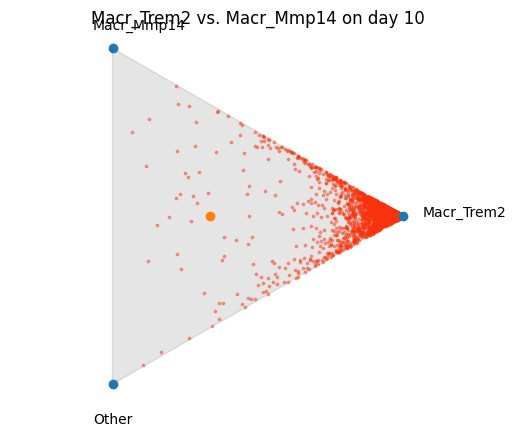

In [150]:
import matplotlib.pyplot as plt
import numpy as np
import math

Nrows = len(fate1)
x = np.zeros(Nrows)
y = np.zeros(Nrows)
P = np.array([[1,0],[np.cos(2*math.pi/3),math.sin(2*math.pi/3)],[math.cos(4*math.pi/3),math.sin(4*math.pi/3)]])

for i in range(0,Nrows):
    ff = np.array([fate1[i],fate2[i],1-(fate1[i]+fate2[i])])
    x[i] = (ff @ P)[0]
    y[i] = (ff @ P)[1]

vx = P[:,0]
vy = P[:,1]
t1 = plt.Polygon(P, color=(0,0,0,0.1))
plt.gca().add_patch(t1)
# for celltype in list(set(ct)):
#     idx = [i for i, x in enumerate(ct) if x == celltype]
#     plt.scatter(x[idx],y[idx],s=1,c=dic_cl[celltype])
plt.scatter(x,y,s=3,c="#f9320c",alpha=0.4)
plt.scatter(vx,vy)
plt.scatter(0,0)
plt.text(P[0,0]+.1, P[0,1], name1)
plt.text(P[1,0]-.1, P[1,1]+.1, name2)
plt.text(P[2,0]-.1, P[2,1]-.2, 'Other')
plt.axis('equal')
plt.axis('off')
#plt.xticks([])
#plt.yticks([])

plt.title('{} vs. {} on day {}'.format(name1, name2,day))
plt.savefig("./figures/Adult_Day10_Mmp14_to_Mmp14andTrem2.pdf",format='pdf')
# plt.savefig("./figures/Adult_Day5_Il0_to_Mmp14andTrem2.pdf",format='pdf')
# plt.savefig("./figures/Adult_Day3_All_to_Il10andSpp1.pdf",format='pdf')
#plt.savefig("./figures/Adult_Day2_Ly6c_to_Il10andSpp1.pdf",format='pdf')